[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/vanguardfox/ads509-group5/blob/main/ADS509_Final_Project.ipynb)

# Assignment 6.2: Preparing Data for Final Team Project
## Group 5
### John Vincent Deniega
### Gabriella Rivera
### Itzel Cruz

# Evaluating Financial Independence / Retire Early (FIRE) Thresholds by Demographic

What is the Financial Independence number the FIRE community is aiming for by age, location, and over time?

# Assignment 6.2 Objective:
Calculate descriptive statistics on your final-project data. You are welcome to reuse code from earlier modules.

(Optional: Install packages as needed)

In [ ]:
#!pip install requests beautifulsoup4

Import Libraries

In [1]:
# Library
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import json
import csv
import requests
import time
import datetime
import nltk
import random
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

from typing import Optional, Tuple
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.util import pairwise
from bs4 import BeautifulSoup
from requests.auth import HTTPBasicAuth
from os import read
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from collections import Counter

## Verify the contents of the CSV that was created from API JSON GET pull and stored as DataFrame

In [2]:
rfire_df = pd.read_csv('fire_comments_mod6.csv')
rfire_df.head()

FileNotFoundError: [Errno 2] No such file or directory: 'fire_comments_mod6.csv'

# Data Preprocessing

## Clean Dataset

In [ ]:
# Retrive titles that contain the words "what is your fire number"
fire_df = rfire_df[rfire_df['Title'].str.contains(r'what\s*is\s*your\s*fire\s*number', case=False, na=False)]

print(fire_df['Title'].unique())
print(fire_df.info())

['What is your fire number? ' 'What is your fire number?'
 'For folks who plan to FIRE in HCOL / VHCOL areas, what is your FIRE number? Why not move to MCOL / LCOL area?'
 'What is your FIRE number?'
 'What is your fire number and how did you arrive at it?'
 'What is your FIRE number and at what age do you want to achieve it by?'
 'Married couples with young kids, what is your FIRE number and how is your progress?']
<class 'pandas.core.frame.DataFrame'>
Index: 432 entries, 0 to 1226
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Thread ID     432 non-null    object
 1   Title         432 non-null    object
 2   User          432 non-null    object
 3   Comment       432 non-null    object
 4   Post Time     432 non-null    object
 5   Comment Time  432 non-null    object
dtypes: object(6)
memory usage: 23.6+ KB
None


### Fire Number Extraction

Regular Expression Description

re.sub(r'[^a-zA-Z0-9\s$€£¥.]', '', text)

replaces matching substrings with an empty '' (effectively removing it)

Breakdown: \
^a-zA-Z0-9 = NOT alphanumeric characters \
\s = whitespace \
$€£¥ = Currency symbols \
. = Period / Decimal \

Objective:  \
Regular Expression removes everything that isn't an alphanumeric character or symbol above AFTER we've already removed periods from the line

text = re.sub(r'(?<!\d)\.(?!\d)', '', text)

Breakdown: \
(?<!\d) Only match if the character before the period is not a digit (\d) *only checking with ?*


In [ ]:
# Define text cleaning and extraction
def clean_and_extract(text: str) -> str:
    """Cleans the input text by normalizing financial identifiers."""
    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Keep alphanumeric characters, spaces, and currency symbols
    text = re.sub(r'[^a-zA-Z0-9\s$€£¥.,/]', '', text)

    # Normalize financial identifiers
    financial_patterns = [
        (r'(?<!\w)\$?(\d{1,3}(?:,\d{3})*(?:\.\d+)?)\s*(m|mm|mil)(?=\s|/|$)', r'\1 million'),
        (r'(?<!\w)\$?(\d{1,3}(?:,\d{3})*(?:\.\d+)?)\s*(b|bil)(?=\s|$)', r'\1 billion'),
        (r'(?<!\w)\$?(\d{1,3}(?:,\d{3})*(?:\.\d+)?)\s*(k|thousand)(?=\s|$)', r'\1 thousand'),
    ]

    for pattern, replacement in financial_patterns:
        text = re.sub(pattern, replacement, text, flags=re.IGNORECASE)

    # Handle ranges and multiple values like "5mil/600k"
    text = re.sub(r'(\d+(?:\.\d+)?)\s*/\s*(\d+(?:\.\d+)?)\s*(mil|m|k)',
                  lambda match: f"{match.group(1)} {match.group(3)} {match.group(2)} {match.group(3)}",
                  text, flags=re.IGNORECASE)

    # Convert to lowercase and remove extra spaces
    text = text.lower()
    text = re.sub(r'\s+', ' ', text).strip()

    return text

def extract_fire_numbers(text: str) -> float:
    """Extracts and converts financial identifiers to numeric values."""
    text = re.sub(r',', '', text)  # Remove commas

    fire_numbers = re.findall(r'(\$?\d+(?:\.\d+)?)\s*(million|billion|thousand|m|b|k)?', text, re.IGNORECASE)

    total = 0.0
    for num, unit in fire_numbers:
        num_value = float(num.replace('$', ''))

        if unit and unit.lower() in ['million', 'm']:
            total = max(total, num_value * 1_000_000)
        elif unit and unit.lower() in ['billion', 'b']:
            total = max(total, num_value * 1_000_000_000)
        elif unit and unit.lower() in ['thousand', 'k']:
            total = max(total, num_value * 1_000)
        else:
            total = max(total, num_value)

    return total

In [ ]:
# Cleaned Comments
fire_df['Cleaned Comment'] = fire_df['Comment'].apply(clean_and_extract)

# Extract FIRE numbers
fire_df['FIRE #'] = fire_df['Cleaned Comment'].apply(extract_fire_numbers)

# Filter out FIRE numbers less than 10,000
fire_df = fire_df[fire_df['FIRE #'] >= 10000]

# Format the FIRE Number for better readability
fire_df['FIRE Number'] = fire_df['FIRE #'].apply(lambda x: f"{x:,.2f}")

# Drop the original FIRE # column
fire_df.drop(columns=['FIRE #'], inplace=True)

### Verify output of cleaning processes

In [ ]:
fire_df[['Comment', 'Cleaned Comment', 'FIRE Number']].tail()

,Comment,Cleaned Comment,FIRE Number
1222,5mil/600k one 3 yr old and newborn coming,5 millionil600k one 3 yr old and newborn coming,5000000.0
1223,Marrying whoever after my Bar Exam this Novemb...,marrying whoever after my bar exam this novemb...,4000000.0
1224,"No kids, 100Mil",no kids 100 million,100000000.0
1225,5m/2.2m with 2 kids in middle/elementary,5 million2.2 million with 2 kids in middleelem...,5000000.0
1226,Is this based of Net worth or liquid asset only?,is this based of net worth or liquid asset only,0.0


In [ ]:
random_sample = fire_df.sample(n=10, random_state=10)
random_sample[['Comment', 'Cleaned Comment', 'FIRE Number']]

,Comment,Cleaned Comment,FIRE Number
65,600k is where I don't worry about expenses. 1....,600 thousand is where i dont worry about expen...,600000.0
266,Could be there right now if I wanted to.\n\nMy...,could be there right now if i wanted to my goa...,2000000.0
188,4M at least. Going to move to Spain,4 million at least going to move to spain,4000000.0
47,"1.2, rent.",1.2 rent,0.0
287,3.6 with mortgage paid.,3.6 with mortgage paid,0.0
1223,Marrying whoever after my Bar Exam this Novemb...,marrying whoever after my bar exam this novemb...,4000000.0
279,7mil. Married w/ 2 kids… 33yo and 30yo. Goal i...,7 millionil married w 2 kids 33yo and 30yo goa...,7000000.0
338,What I want to pull out my first year x28.5 in...,what i want to pull out my first year x28.5 in...,0.0
163,2 - 3 Mil,2 3 million,3000000.0
357,"$2,000,000 gives us $80,000/year. That’s what ...",$2000000 gives us $80000year thats what ive wo...,0.0


### Year Extraction

In [ ]:
fire_df['Post Year'] = pd.to_datetime(fire_df['Post Time']).dt.year
fire_df['Comment Year'] = pd.to_datetime(fire_df['Comment Time']).dt.year

In [ ]:
# Display the first few rows of the DataFrame
#print("FIRE Dataframe\n")
fire_df.head()
#print()

# Print general information about the DataFrame with a proper newline
#print("FIRE DataFrame General Info\n")
#print(fire_df.info())

,Thread ID,Title,User,Comment,Post Time,Comment Time,Cleaned Comment,FIRE Number,Post Year,Comment Year
0,1fqzb0p,What is your fire number?,manimopo,1.5m with paid off houses,2024-09-27 22:00:15,2024-09-27 22:14:27,1.5 million with paid off houses,1500000.0,2024,2024
1,1fqzb0p,What is your fire number?,Animag771,I'm just waiting for someone to say something ...,2024-09-27 22:00:15,2024-09-27 22:43:43,im just waiting for someone to say something l...,0.0,2024,2024
2,1fqzb0p,What is your fire number?,wowsocool4u,$1.9m. Targeting a few months after i turn 50...,2024-09-27 22:00:15,2024-09-27 22:24:04,1.9 million targeting a few months after i tur...,1900000.0,2024,2024
3,1fqzb0p,What is your fire number?,Aromatic_Heart,"On days I hate my job, 600k. The other days, d...",2024-09-27 22:00:15,2024-09-28 03:15:50,on days i hate my job 600k the other days depe...,3000000.0,2024,2024
4,1fqzb0p,What is your fire number?,Ziqach,$2M with a paid off house. So stressful to see...,2024-09-27 22:00:15,2024-09-27 22:59:17,2 million with a paid off house so stressful t...,2000000.0,2024,2024


## *Assignment 6.2 Objective: Descriptive Stats*

### Combine all comments into a single text, tokenize, and call descriptive_stats

In [ ]:
combined_comments = ' '.join(fire_df['Cleaned Comment'].astype(str))
tokens = nltk.word_tokenize(combined_comments)
descriptive_stats(tokens)

There are 16659 tokens in the data.
There are 2549 unique tokens in the data.
There are 69244 characters in the data.
The lexical diversity is 0.153 in the data.
The five most common tokens are:
to: 480
i: 480
a: 423
and: 385
million: 377




[16659, 2549, 0.1530103847769974, 69244]

### Graph number of posts by year

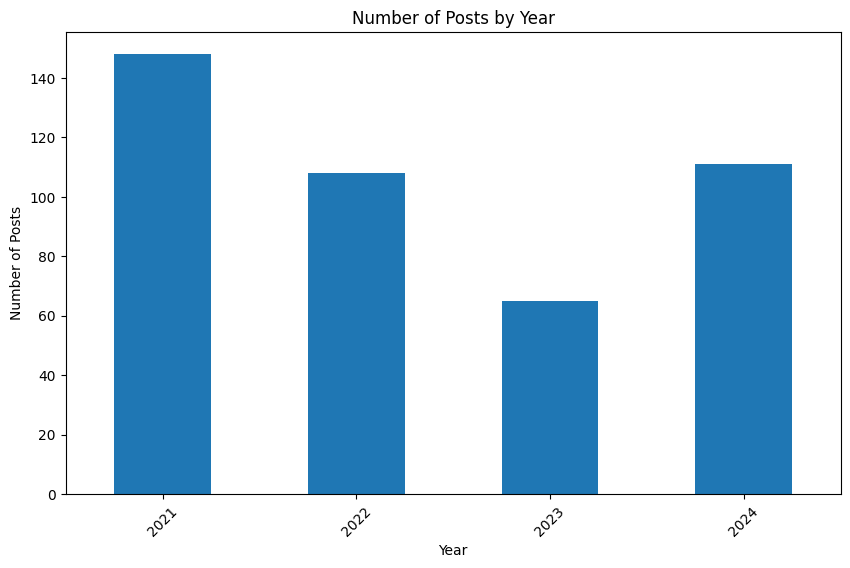

In [ ]:
post_counts_by_year = fire_df.groupby('Post Year').size()
plt.figure(figsize=(10, 6))
post_counts_by_year.plot(kind='bar')
plt.title('Number of Posts by Year')
plt.xlabel('Year')
plt.ylabel('Number of Posts')
plt.xticks(rotation=45)
plt.show()

### Handle outliers (1.5*IQR +/- Q1|Q3 Method)

In [ ]:
def cap_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return series.clip(lower=lower_bound, upper=upper_bound)

In [ ]:
fire_df['Capped FIRE Number'] = cap_outliers(fire_df['FIRE Number'])

### Mean and Median FIRE number by Post Year

In [ ]:
mean_fire_by_post_year = fire_df.groupby('Post Year')['Capped FIRE Number'].mean()
median_fire_by_post_year = fire_df.groupby('Post Year')['Capped FIRE Number'].median()
fire_stats_by_post_year = pd.DataFrame({
    'Mean FIRE': mean_fire_by_post_year,
    'Median FIRE': median_fire_by_post_year
})
pd.options.display.float_format = '{:,.2f}'.format
fire_stats_by_post_year

,Mean FIRE,Median FIRE
Post Year,,
2021,"2,461,520.27","2,000,000.00"
2022,"1,111,925.93",0.00
2023,"2,338,184.62","1,700,000.00"
2024,"2,190,981.98","1,600,000.00"


### Mean and Median FIRE number by Comment Year

In [ ]:
mean_fire_by_comment_year = fire_df.groupby('Comment Year')['Capped FIRE Number'].mean()
median_fire_by_comment_year = fire_df.groupby('Comment Year')['Capped FIRE Number'].median()
fire_stats_by_comment_year = pd.DataFrame({
    'Mean FIRE': mean_fire_by_comment_year,
    'Median FIRE': median_fire_by_comment_year
})
pd.options.display.float_format = '{:,.2f}'.format
fire_stats_by_comment_year

,Mean FIRE,Median FIRE
Comment Year,,
2021,"2,451,054.42","2,000,000.00"
2022,"1,111,925.93",0.00
2023,"2,370,031.25","1,850,000.00"
2024,"2,190,256.64","1,600,000.00"


### Create CountVectorizer matrix for the cleaned comments

In [ ]:
vectorizer_ct = CountVectorizer(stop_words='english')
X_ct = vectorizer_ct.fit_transform(fire_df['Cleaned Comment'])

### Create Term Frequency - Inverse Document Frequency scored vectors

In [ ]:
vectorizer_tfidf = TfidfVectorizer(stop_words='english', max_features=1000) # Cap the size for memory
X_tfidf = vectorizer_tfidf.fit_transform(fire_df['Cleaned Comment'])

# Model Development

## Topic Modeling

### Latent Dirichlet Allocation

In [ ]:
lda = LatentDirichletAllocation(n_components=5, random_state=509)
lda.fit(X_ct)

LatentDirichletAllocation(n_components=5, random_state=509)

#### Examine topics from LDA at n=5 topics (arbritrary)

In [ ]:
def display_topics(model, feature_names, num_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")

        #For each topic, go through index i and retrieve word from that location
        #Topic is a vector of weights of each word for a given topic (higher = more important)
        #argsort() return indices of elements in topic in ascending importance
        #:-num_top_words - 1 = Start from last element -1 and move back num_top_words positions
        # --- This is to remove the lesser important words for interpretation purposes
        # -1 reverse order so it's descending now that noisy words are removed.
        print(" ".join([feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]))

In [ ]:
feature_names_lda = vectorizer_ct.get_feature_names_out()
num_top_words = 10
display_topics(lda, feature_names_lda, num_top_words)

Topic 0:
million thousand years want im ill goal number year income
Topic 1:
million number cash im living college money income kids job
Topic 2:
million 10 kids deleted job travel dont years number like
Topic 3:
million paid im house years kids number live family area
Topic 4:
million thousand number house live paid im years expenses want


#### Result
Selecting n_components=5 might not be the correct number of topics to be able to clearly separate words into themes. Need to try another topic number.

### Retry LDA with n_components=8

In [ ]:
lda = LatentDirichletAllocation(n_components=8, random_state=509)
lda.fit(X_ct)
feature_names_lda = vectorizer_ct.get_feature_names_out()
num_top_words = 10
display_topics(lda, feature_names_lda, num_top_words)

Topic 0:
million live want year just need expenses goal years work
Topic 1:
million number living area money im home think moving vhcol
Topic 2:
million want kids job thousand life like dont good work
Topic 3:
million paid house years number kids im just family live
Topic 4:
million thousand house paid number live years im expenses retire
Topic 5:
million thousand im years cash 10 45 income currently ill
Topic 6:
thousand im net million income time travel retirement number worth
Topic 7:
million deleted area want family years house hcol live plan


## DEPENDENCY.
Need to find a way to import a date of post or age of post so the model below can extract some sort of time or year for a time-series chart. Else, will have to select a different groupby.

### Sentiment Analysis with VaderSentiment

Reference

Hutto, C. J., Klein, E., Pantone, P., Berry, G., & Suresh, M. (2024, August 19). Documentation source code for nltk.sentiment.vader. https://www.nltk.org/_modules/nltk/sentiment/vader.html

In [ ]:
#nltk.download('vader_lexicon')

In [ ]:
analyzer = SentimentIntensityAnalyzer() # Intialize the analyzer as object

In [ ]:
def get_sentiment_score(comment):
    scores = analyzer.polarity_scores(comment)
    return pd.Series([scores['neg'], scores['neu'], scores['pos'], scores['compound']],
                    index=['Negative', 'Neutral', 'Positive', 'Compound'])

In [ ]:
fire_df[['Negative', 'Neutral', 'Positive', 'Compound']] = fire_df['Cleaned Comment'].apply(get_sentiment_score)

In [ ]:
fire_df[['Cleaned Comment', 'Negative', 'Neutral', 'Positive', 'Compound', 'FIRE Number']].head(10)

,Cleaned Comment,Negative,Neutral,Positive,Compound,FIRE Number
0,1.5 million with paid off houses,0.00,1.00,0.00,0.00,"1,500,000.00"
1,im just waiting for someone to say something l...,0.17,0.83,0.00,-0.40,0.00
2,1.9 million targeting a few months after i tur...,0.07,0.93,0.00,-0.15,"1,900,000.00"
3,on days i hate my job 600k the other days depe...,0.17,0.83,0.00,-0.57,"3,000,000.00"
4,2 million with a paid off house so stressful t...,0.23,0.77,0.00,-0.64,"2,000,000.00"
5,our target back in 2014 was 1.2 million and a ...,0.06,0.87,0.07,-0.34,"1,200,000.00"
6,500 thousand give or take but i am not retirin...,0.00,1.00,0.00,0.00,"500,000.00"
7,i started at 1.5 million 1015 years ago now be...,0.06,0.80,0.15,0.40,"1,500,000.00"
8,re ship sailed but still working on fi house i...,0.00,0.91,0.09,0.61,"4,000,000.00"
9,funny to read all these numbers while the medi...,0.00,0.66,0.34,0.77,0.00


### OPTIONAL:GROUPBY ANALYSIS, which requires additional JSON features to be pulled into CSV

In [ ]:
fire_df.columns

Index(['Thread ID', 'Title', 'User', 'Comment', 'Post Time', 'Comment Time',
       'Cleaned Comment', 'FIRE Number', 'Post Year', 'Comment Year',
       'Capped FIRE Number', 'Negative', 'Neutral', 'Positive', 'Compound'],
      dtype='object')

In [ ]:
sentiment_by_year = fire_df.groupby('Comment Year')[['Negative', 'Neutral', 'Positive', 'Compound']].mean()
sentiment_by_year_plus_fire = pd.merge(sentiment_by_year,
                                       fire_stats_by_comment_year,
                                       left_index=True,
                                       right_index=True)
sentiment_by_year_plus_fire

,Negative,Neutral,Positive,Compound,Mean FIRE,Median FIRE
Comment Year,,,,,,
2021,0.03,0.88,0.09,0.18,"2,451,054.42","2,000,000.00"
2022,0.05,0.83,0.12,0.28,"1,111,925.93",0.00
2023,0.06,0.89,0.05,-0.01,"2,370,031.25","1,850,000.00"
2024,0.05,0.89,0.06,0.03,"2,190,256.64","1,600,000.00"


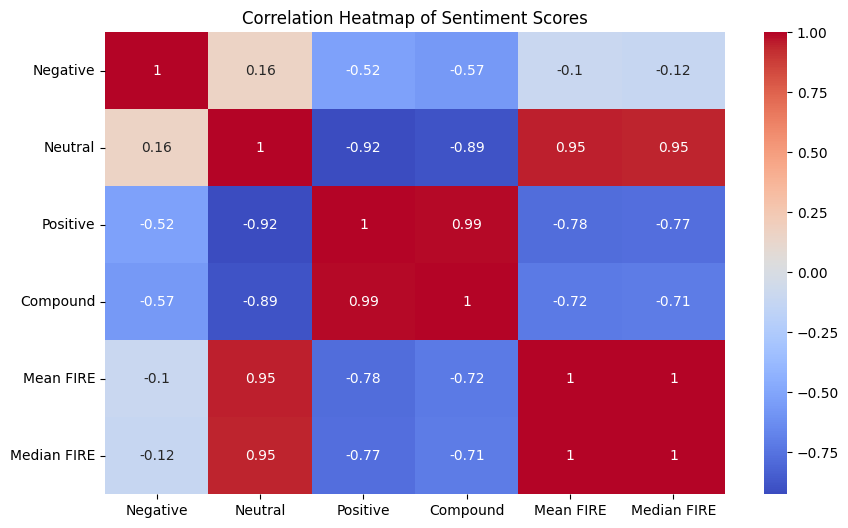

In [ ]:
year_pearson = sentiment_by_year_plus_fire.corr(method='pearson')
plt.figure(figsize=(10, 6))
sns.heatmap(year_pearson, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Sentiment Scores')
plt.show()

#### Interpretation

Sentiment analysis appears to show that 2022 was especially positive using text comments whereas 2023 was the only net negative year. This tracks with the US inflation crisis that occured over this period. Interestingly, there is a strong negative correlation between mean and median FIRE number and positive sentiment. This may be due to optimism that the purchasing power of the currency in question is sufficient for retirement purposes.

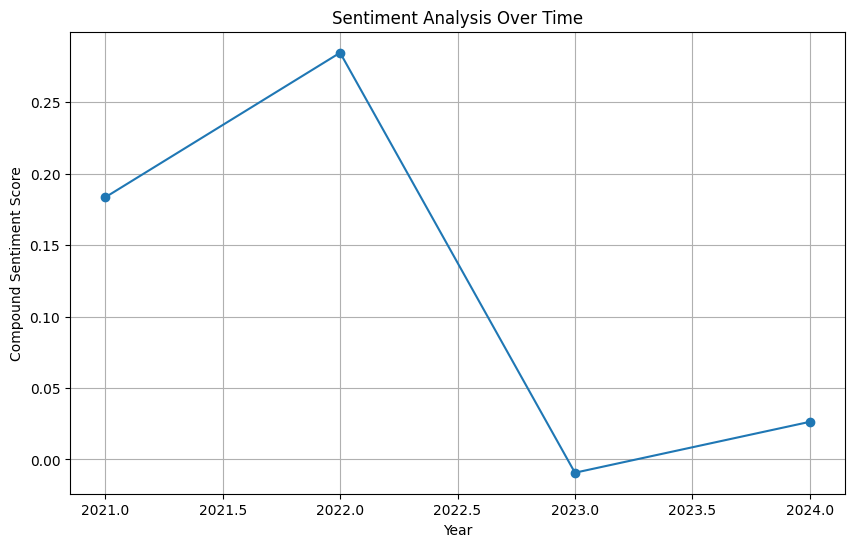

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(sentiment_by_year.index, sentiment_by_year['Compound'], marker='o')
plt.title('Sentiment Analysis Over Time')
plt.xlabel('Year')
plt.ylabel('Compound Sentiment Score')
plt.grid(True)
plt.show()

### Latent Semantic Analysis

In [ ]:
n_topics = 5
lsa = TruncatedSVD(n_components=n_topics, random_state=509) # Initialize model
lsa_topic_matrix = lsa.fit_transform(X_tfidf) # Fit and transform for latent topics

In [ ]:
feature_names_tfidf = vectorizer_tfidf.get_feature_names_out()

In [ ]:
display_topics(lsa, feature_names_tfidf, num_top_words) # Show top 10 words for each topic

Topic 0:
million house paid 10 thousand kids years im live liquid
Topic 1:
deleted 25 cash ill withdrawal debt 10 goal 53 fat
Topic 2:
million 10 5055 33 40 germany div ski million3 19
Topic 3:
house paid plus kid 53 fat 45 65 mcol nyc
Topic 4:
area live family vhcol want friends hcol kids house love
